In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
import time
from astropy import units
from numpy import random
import clmm.dataops as da
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
np.random.seed(0)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e16 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = [0.2, 0.05, 0.01]  # True ellipticity standard variation
# shapenoise    = [0.05]  # True ellipticity standard variation

# Create galaxy catalog and Cluster object

def create_nc_data_cluster_wl (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r  = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    ga = Ncm.ObjArray.new ()
    
    sigma_g = 1.0e-4 if not sigma_g else sigma_g
    m_obs = np.column_stack ((r, g_t, np.repeat (sigma_g, len (r))))
    
    grsg = Nc.GalaxyWLEllipticityGauss (pos = Nc.GalaxyWLEllipticityGaussPos.R)
    grsg.set_obs (Ncm.Matrix.new_array (m_obs.flatten (), 3))
    

    gzgs = Nc.GalaxyRedshiftSpec ()
    gzgs.set_z (Ncm.Vector.new_array (z_source))

    gwl  = Nc.GalaxyWL (wl_dist = grsg, gz_dist = gzgs)
    ga.add (gwl)

    nc_dcwl = Nc.DataClusterWL (galaxy_array = ga, z_cluster = z_cluster)
    nc_dcwl.set_init (True)
    
    return nc_dcwl

def create_nc_data_cluster_wl_kde (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r  = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    ga = Ncm.ObjArray.new ()
    
    sigma_g = 1.0e-4 if not sigma_g else sigma_g
    m_obs = np.column_stack ((r, g_t, np.repeat (sigma_g, len (r))))
    
    grsg = Nc.GalaxyWLEllipticityKDE ()
    grsg.set_obs (Ncm.Matrix.new_array (m_obs.flatten (), 3))
    

    gzgs = Nc.GalaxyRedshiftSpec ()
    gzgs.set_z (Ncm.Vector.new_array (z_source))

    gwl  = Nc.GalaxyWL (wl_dist = grsg, gz_dist = gzgs)
    ga.add (gwl)

    nc_dcwl = Nc.DataClusterWL (galaxy_array = ga, z_cluster = z_cluster)
    nc_dcwl.set_init (True)
    
    return nc_dcwl

def create_fit_obj (data_array, mset):
    dset = Ncm.Dataset.new ()
    for data in data_array:
        dset.append_data (data)
    lh = Ncm.Likelihood.new (dset)
    fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

    return fit

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#..

/tmp/ipykernel_35664/1913660486.py:22: Warning: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
  fit.run (Ncm.FitRunMsgs.SIMPLE)


................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:04.9720710
#  iteration            [000094]
#  function evaluations [000096]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =    -2961.63661150005 (    -2961.6366 )
#  Fit parameters:
#     3.37283956510596     16.0424344808809    
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterWL
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -          H0[00]:  70                  [FIXED]
#   -      Omegac[01]:  0.225               [FIXED]
#   -      Omegak[02]:  0                   [FIXED]
#   -     Tgamma0[03]:  2.7255              [FIXED]
#   -          Yp[


(process:35664): NUMCOSMO-WARNING **: 02:11:22.359: ncm_fit_fisher_to_covar: covariance matrix not positive definite, errors are not trustworthy.
sys:1: Warning: g_object_unref: assertion 'G_IS_OBJECT (object)' failed


# NcmMSetCatalog: Current mean:  -2949.5       3.3723       16.042     
# NcmMSetCatalog: Current msd:    1.3994       0.00070314   0.0033231  
# NcmMSetCatalog: Current sd:     19.791       0.0099439    0.046996   
# NcmMSetCatalog: Current var:    391.67       9.8881e-05   0.0022086  
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       393.402880283627 (2n = 4), min(-2ln(L)) =      -2961.63020182188.
# Task:NcmFitESMCMC, completed: 200 of 200, elapsed time: 00:00:02.4234
# Task:NcmFitESMCMC, mean time: 00:00:00.0119 +/- 00:00:00.0119
# Task:NcmFitESMCMC, time

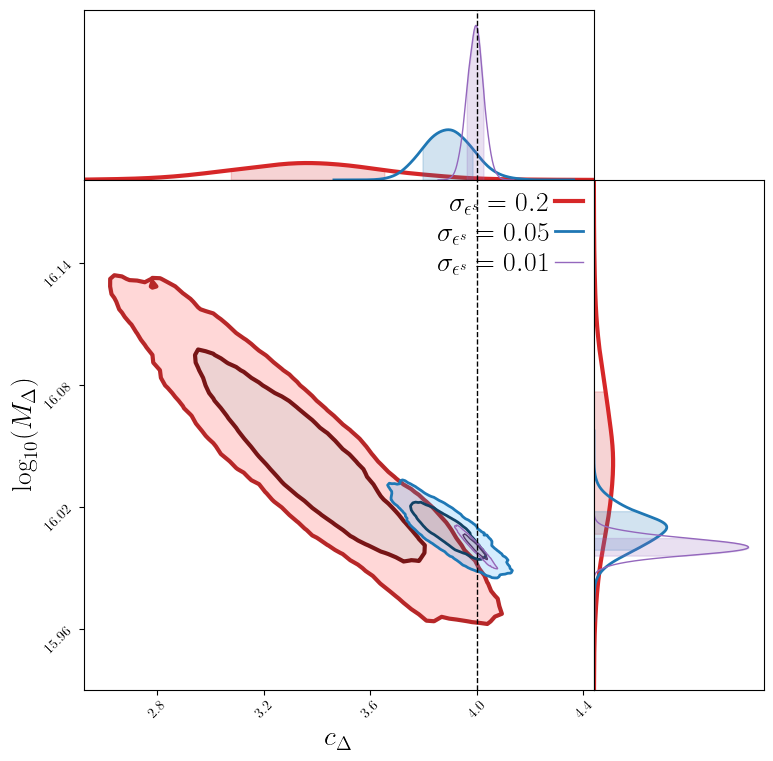

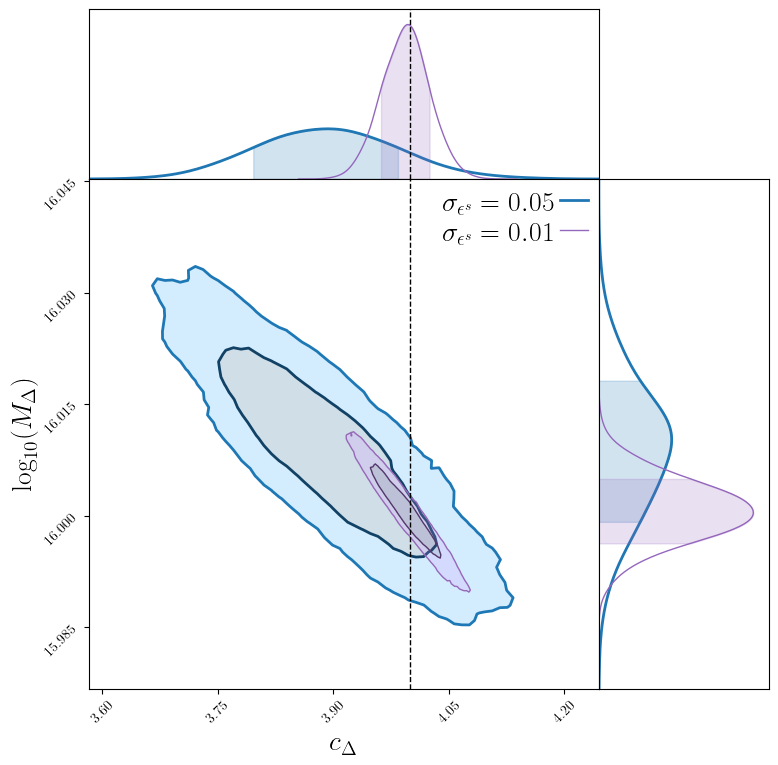

In [3]:
total = ChainConsumer()

for sn in shapenoise:

    moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
    moo.set_cosmo(cosmo)
    mset = moo.get_mset ()

    MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
    cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

    mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
    mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
    mset.prepare_fparam_map ()

    data = mock.generate_galaxy_catalog( cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sn, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
    gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
    gc.compute_tangential_and_cross_components(geometry="flat")

    ggt = create_nc_data_cluster_wl_kde(gc.galcat['theta'], gc.galcat['et'], gc.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_g=sn)
    fit = create_fit_obj ([ggt], mset)
    fit.run (Ncm.FitRunMsgs.SIMPLE)
    fit.obs_fisher ()
    fit.log_info ()
    fit.log_covar ()

    print(10**mset.param_get(MDelta_pi.mid, MDelta_pi.pid))

    Ncm.func_eval_set_max_threads (4)
    Ncm.func_eval_log_pool_stats ()

    init_sampler = Ncm.MSetTransKernGauss.new (0)
    init_sampler.set_mset (mset)
    init_sampler.set_prior_from_mset ()
    init_sampler.set_cov_from_rescale (1.0e-1)

    nwalkers = 200
    stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
    esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
    esmcmc.set_data_file (f"Fits/KDE_lh_{sn}.fits")
    esmcmc.set_auto_trim_div (100)
    esmcmc.set_max_runs_time (2.0 * 60.0)
    esmcmc.set_nthreads(4)
    esmcmc.start_run()
    esmcmc.run(10000/nwalkers)
    esmcmc.end_run()

    mcat = esmcmc.peek_catalog()
    rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
    params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

    # partial = ChainConsumer()
    # partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sn}$")
    # partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

    # CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 15])

    # fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")
    # fig.savefig(f"Plots/MCMC/KDE_lh_corner_{sn}.png")


    total.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sn}$")

total.configure(spacing=0.0, usetex=True, colors=['#D62728', '#1F77B4', "#9467BD"], shade=True, shade_alpha=0.2, bar_shade=True, label_font_size=20, smooth=[True, True, True,], kde=[True, True, True], legend_color_text=False, linewidths=[3, 2, 1], linestyles=["-", "-", "-"], sigmas=[1,2])

total_fig = total.plotter.plot(figsize=(8,8), truth=[4, 15])
fig = plt.figure(num=total_fig, figsize=(8,8), dpi=300, facecolor="white")
# fig.savefig(f"Plots/MCMC/KDE_lh_corner.png")

total_fig = total.plotter.plot(figsize=(8, 8), truth=[4, 15], chains=[f"$\sigma_{{\epsilon^s}} = {shapenoise[1]}$", f"$\sigma_{{\epsilon^s}} = {shapenoise[2]}$"])
fig = plt.figure(num=total_fig, figsize=(8,8), dpi=300, facecolor="white")
# fig.savefig(f"Plots/MCMC/KDE_lh_corner_zoom.png")


In [4]:
total = ChainConsumer()

for sn in shapenoise:

    moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
    moo.set_cosmo(cosmo)
    mset = moo.get_mset ()

    MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
    cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

    mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
    mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
    mset.prepare_fparam_map ()

    data = mock.generate_galaxy_catalog( cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sn, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
    gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
    gc.compute_tangential_and_cross_components(geometry="flat")

    ggt = create_nc_data_cluster_wl_kde (gc.galcat['theta'], gc.galcat['et'], gc.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_g=sn)
    fit = create_fit_obj ([ggt], mset)
    fit.run (Ncm.FitRunMsgs.SIMPLE)
    fit.obs_fisher ()
    fit.log_info ()
    fit.log_covar ()

    print(10**mset.param_get(MDelta_pi.mid, MDelta_pi.pid))

    Ncm.func_eval_set_max_threads (4)
    Ncm.func_eval_log_pool_stats ()

    init_sampler = Ncm.MSetTransKernGauss.new (0)
    init_sampler.set_mset (mset)
    init_sampler.set_prior_from_mset ()
    init_sampler.set_cov_from_rescale (1.0e-1)

    nwalkers = 200
    stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
    esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
    esmcmc.set_data_file (f"Fits/KDE_lh_{sn}.fits")
    esmcmc.set_auto_trim_div (100)
    esmcmc.set_max_runs_time (2.0 * 60.0)
    esmcmc.set_nthreads(4)
    esmcmc.start_run()
    esmcmc.run(10000/nwalkers)
    esmcmc.end_run()

    mcat = esmcmc.peek_catalog()
    rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
    params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

    # partial = ChainConsumer()
    # partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sn}$")
    # partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

    # CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 15])

    # fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")
    # fig.savefig(f"Plots/MCMC/KDE_lh_corner_{sn}.png")


    total.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sn}$")

total.configure(spacing=0.0, usetex=True, colors=['#D62728', '#1F77B4', "#9467BD"], shade=True, shade_alpha=0.2, bar_shade=True, label_font_size=20, smooth=[True, True, True,], kde=[True, True, True], legend_color_text=False, linewidths=[3, 2, 1], linestyles=["-", "-", "-"], sigmas=[1,2])

total_fig = total.plotter.plot(figsize=(8,8), truth=[4, 15])
fig = plt.figure(num=total_fig, figsize=(8,8), dpi=300, facecolor="white")
# fig.savefig(f"Plots/MCMC/KDE_lh_corner.png")

total_fig = total.plotter.plot(figsize=(8, 8), truth=[4, 15], chains=[f"$\sigma_{{\epsilon^s}} = {shapenoise[1]}$", f"$\sigma_{{\epsilon^s}} = {shapenoise[2]}$"])
fig = plt.figure(num=total_fig, figsize=(8,8), dpi=300, facecolor="white")
# fig.savefig(f"Plots/MCMC/KDE_lh_corner_zoom.png")


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.....

/tmp/ipykernel_35664/1854412469.py:22: Warning: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
  fit.run (Ncm.FitRunMsgs.SIMPLE)


............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:02.6663690
#  iteration            [000082]
#  function evaluations [000084]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =    -3060.88258669895 (    -3060.8826 )
#  Fit parameters:
#     3.12828958072444     16.0645869372346    
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterWL
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -          H0[00]:  70                  [FIXED]
#   -      Omegac[01]:  0.225               [FIXED]
#   -      Omegak[02]:  0                   [FIXED]
#   -     Tgamma0[03]:  2.7255              [FIXED]
#   -          Yp[04]:


(process:35664): NUMCOSMO-WARNING **: 02:15:34.156: ncm_fit_fisher_to_covar: covariance matrix not positive definite, errors are not trustworthy.


# NcmFitESMCMC: Catalog row  9800: m2lnL =    -2961.62673866426, recalculated to     -3060.2702730598, diff = 3.33072e-02 <====== FAILED.
# NcmFitESMCMC: row  9800 values:      -2961.62673866426       3.38038546468294       16.0403146147577


sys:1: Warning: g_object_unref: assertion 'G_IS_OBJECT (object)' failed


# NcmFitESMCMC: Catalog row  9801: m2lnL =    -2958.72374233745, recalculated to     -3058.5874213656, diff = 3.37523e-02 <====== FAILED.
# NcmFitESMCMC: row  9801 values:      -2958.72374233745       3.34669426973849       16.0221328799294
# NcmFitESMCMC: Catalog row  9802: m2lnL =    -2961.41832444247, recalculated to    -3060.69984259091, diff = 3.35250e-02 <====== FAILED.
# NcmFitESMCMC: row  9802 values:      -2961.41832444247       3.25438650460872       16.0541903605584
# NcmFitESMCMC: Catalog row  9806: m2lnL =    -2961.26273465904, recalculated to    -3060.78752927974, diff = 3.36089e-02 <====== FAILED.
# NcmFitESMCMC: row  9806 values:      -2961.26273465904       3.22307691357282       16.0564231160646
# NcmFitESMCMC: Catalog row  9804: m2lnL =    -2961.09386436002, recalculated to    -3058.97868860631, diff = 3.30570e-02 <====== FAILED.
# NcmFitESMCMC: row  9804 values:      -2961.09386436002       3.57270325909286       16.0208123383018
# NcmFitESMCMC: Catalog row  9805: m